In [341]:
import numpy as np
import pandas as pd
import re
from scipy.stats import norm

from matplotlib import pyplot as plt
from data_util import create_dataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.cluster import DBSCAN

pd.options.display.max_rows = 100
pd.set_option('display.max_rows', None)

# Read in data

###  Note that the loaded data has already been log_2(x+1) transformed from the raw values

In [2]:
# Read in new data
filepath_new = '../mmc1-tony.xlsx'
data_new = pd.read_excel(filepath_new,index_col=0)

In [279]:
data_BRCA_lung = create_dataset(cancer_type = 'BRCA',
                                new_tumor_event_site = 'Lung',
                                data_new = data_new,
                                filepath_ge = '../BRCA/TCGA-BRCA.htseq_fpkm.tsv',
                                filepath_ph = '../BRCA/TCGA-BRCA.GDC_phenotype.tsv')

In [280]:
data_BRCA_lung

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3,sample_id,bcr_patient_barcode,new_tumor_event_site,sample_type.samples
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A3XS-01A,0.000000,0.000000,2.188195,0.000000,1.748448,3.943407,0.000000,0.016324,7.308638,0.000000,...,0.195737,3.972232,0.349083,0.0,0.986316,0.0,TCGA-A2-A3XS-01A,TCGA-A2-A3XS,Lung,Primary Tumor
TCGA-B6-A409-01A,0.000000,0.000000,1.592924,0.000000,0.907229,3.270728,0.071389,0.157954,7.320173,0.078148,...,0.000000,3.448320,0.279186,0.0,1.320473,0.0,TCGA-B6-A409-01A,TCGA-B6-A409,Lung,Primary Tumor
TCGA-B6-A0I1-01A,0.000000,0.008025,1.566140,0.000000,2.080369,2.726910,0.000000,0.169888,8.075526,0.026461,...,0.047540,2.601373,1.057151,0.0,0.992014,0.0,TCGA-B6-A0I1-01A,TCGA-B6-A0I1,Lung,Primary Tumor
TCGA-BH-A1EY-01A,0.000000,0.006257,2.287106,0.000000,2.294679,3.938652,0.000000,0.941261,6.955325,0.080917,...,0.000000,4.374549,0.331327,0.0,0.600684,0.0,TCGA-BH-A1EY-01A,TCGA-BH-A1EY,Lung,Primary Tumor
TCGA-EW-A1P1-01A,0.091184,0.000000,1.680844,0.000000,2.855336,3.267594,0.000000,0.011125,7.184775,0.239088,...,0.000000,3.762484,0.222120,0.0,1.516585,0.0,TCGA-EW-A1P1-01A,TCGA-EW-A1P1,Lung,Primary Tumor
TCGA-AR-A5QQ-01A,0.000000,0.000000,2.050921,0.000000,2.513511,3.040755,0.000000,0.108066,7.331879,0.253488,...,0.000000,3.947990,0.097843,0.0,1.293070,0.0,TCGA-AR-A5QQ-01A,TCGA-AR-A5QQ,Lung,Primary Tumor
TCGA-E2-A1LE-01A,0.072704,0.000000,2.326930,0.000000,2.295381,3.601933,0.000000,0.005299,8.107163,0.162199,...,0.000000,3.741809,0.071371,0.0,0.915310,0.0,TCGA-E2-A1LE-01A,TCGA-E2-A1LE,Lung,Primary Tumor
TCGA-EW-A1P8-01A,0.000000,0.000000,1.749768,0.000000,3.565526,3.109890,0.000000,0.006606,6.917720,0.031766,...,0.056990,5.003280,0.318117,0.0,0.620852,0.0,TCGA-EW-A1P8-01A,TCGA-EW-A1P8,Lung,Primary Tumor
TCGA-3C-AAAU-01A,0.000000,0.000000,2.225387,0.000000,1.498832,3.771037,0.000000,0.004982,7.086283,0.031925,...,0.057271,4.464153,0.308488,0.0,0.326940,0.0,TCGA-3C-AAAU-01A,TCGA-3C-AAAU,Lung,Primary Tumor


In [35]:
### Selecting genes related to transporters and enzymes

In [281]:
col_trunc_list = [x[:15] for x in data_BRCA_lung.columns[:-4]]
col_trunc_df = pd.DataFrame(col_trunc_list)
col_trunc_df = pd.concat([col_trunc_df,pd.DataFrame(data_BRCA_lung.columns[:-4])],axis=1)
col_trunc_df.columns = ['ensembl_gene_id','og_index']

In [282]:
names_df = pd.read_csv('../ensembl_index.csv',index_col = 0)
final_names = pd.merge(names_df,col_trunc_df)

In [283]:
gene_list = final_names.og_index.tolist()

In [284]:
feature_list = gene_list + ['sample_id', 'bcr_patient_barcode', 'new_tumor_event_site','sample_type.samples']

In [285]:
u,c = np.unique(feature_list,return_counts=True)
u[c>1]

array(['ENSG00000099977.12', 'ENSG00000100197.19', 'ENSG00000104205.11',
       'ENSG00000104237.6', 'ENSG00000112541.12', 'ENSG00000114316.11',
       'ENSG00000114374.11', 'ENSG00000124713.5', 'ENSG00000128383.11',
       'ENSG00000130035.5', 'ENSG00000133816.12', 'ENSG00000137843.10',
       'ENSG00000160209.17', 'ENSG00000163156.10', 'ENSG00000172352.5',
       'ENSG00000182415.9', 'ENSG00000223443.2', 'ENSG00000241370.4',
       'ENSG00000257365.6'], dtype='<U20')

In [286]:
data_BRCA_lung = data_BRCA_lung[feature_list]
data_BRCA_lung = data_BRCA_lung.loc[:,~data_BRCA_lung.columns.duplicated()]

In [287]:
data_BRCA_lung.drop('TCGA-E9-A1NF-11A',inplace=True)

### Histogram

In [288]:
X_df = data_BRCA_lung.drop(columns=['sample_id','bcr_patient_barcode','new_tumor_event_site',])
X_tumor_df = X_df[X_df['sample_type.samples']=="Primary Tumor"]
X_tumor_df = X_tumor_df.drop(columns = 'sample_type.samples')
# scaler = StandardScaler()
# scaler.fit_transform(X_tumor_df)
# X_scaled = scaler.transform(X_tumor_df)
# mean_vec = scaler.mean_
# var_vec = scaler.var_

In [289]:
mean_vec = X_tumor_df.mean()

Text(0.5, 0, 'Mean')

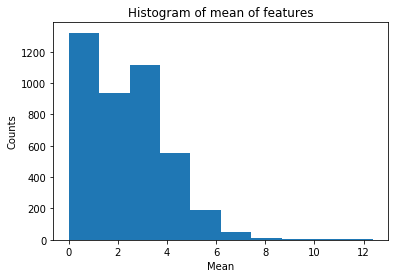

In [290]:
plt.hist(mean_vec)

plt.title('Histogram of mean of features')
plt.ylabel('Counts')
plt.xlabel('Mean')

Text(0.5, 0, 'Mean')

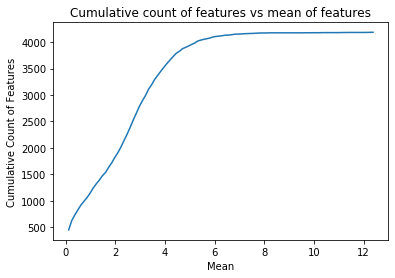

In [272]:
hist, bin_edges = np.histogram(mean_vec,bins=100)
plt.plot(bin_edges[1:],np.cumsum(hist))
plt.title('Cumulative count of features vs mean of features')
plt.ylabel('Cumulative Count of Features')
plt.xlabel('Mean')

## Standardize

In [239]:
# X_df = data_BRCA_lung.drop(columns=['sample_id','bcr_patient_barcode','new_tumor_event_site',])
# X_tumor_df = X_df[X_df['sample_type.samples']=="Primary Tumor"]
# X_tumor_df = X_tumor_df.drop(columns = 'sample_type.samples')
# scaler = StandardScaler()
# scaler.fit_transform(X_tumor_df)
# X_scaled = pd.DataFrame(scaler.transform(X_tumor_df))
# X_scaled.columns = X_tumor_df.columns
# X_scaled.index = X_tumor_df.index

## Drop according to mean and variance of each feature (This is currently not working, skip this part

In [15]:
'''
mean_vec = scaler.mean_
var_vec = scaler.var_
cutoff_num = 6 # We want 1-cutoff_prob of the distribution to be above this number
cutoff_prob=.05
keep_vec = []
zeros_vec = []
nan_vec = []
for ii in range(len(mean_vec)):
    mean = mean_vec[ii]
    variance = var_vec[ii]
    distribution = norm(loc=mean,scale=variance)
    cum_prob = distribution.cdf(cutoff_num)
    if np.isnan(cum_prob):
        nan_vec.append(ii)
    if cum_prob >= cutoff_prob: # Drop when cutoff_prob
        keep_vec.append(ii)
    if (mean_vec[ii] == 0) or (var_vec[ii] == 0):
        zeros_vec.append(ii)
    else:
        pass
'''

'\nmean_vec = scaler.mean_\nvar_vec = scaler.var_\ncutoff_num = 6 # We want 1-cutoff_prob of the distribution to be above this number\ncutoff_prob=.05\nkeep_vec = []\nzeros_vec = []\nnan_vec = []\nfor ii in range(len(mean_vec)):\n    mean = mean_vec[ii]\n    variance = var_vec[ii]\n    distribution = norm(loc=mean,scale=variance)\n    cum_prob = distribution.cdf(cutoff_num)\n    if np.isnan(cum_prob):\n        nan_vec.append(ii)\n    if cum_prob >= cutoff_prob: # Drop when cutoff_prob\n        keep_vec.append(ii)\n    if (mean_vec[ii] == 0) or (var_vec[ii] == 0):\n        zeros_vec.append(ii)\n    else:\n        pass\n'

# Drop according to mean (Drop if mean < 6, keep if mean >=6)

In [316]:
X_filtered = X_tumor_df[X_tumor_df.columns[mean_vec>=2]]

In [318]:
X_filtered.shape

(15, 2361)

In [319]:
breast_genes_c = [gene for gene in X_filtered.columns]
breast_genes_c_trunc = [x[:15] for x in breast_genes_c]

In [320]:
len(breast_genes_c_trunc), len(np.unique(breast_genes_c_trunc))

(2361, 2361)

In [321]:
BRCA_lung_trunc_df = X_filtered
BRCA_lung_trunc_df.columns = breast_genes_c_trunc

# Differential Gene Expression Analysis

In [322]:
# Read in healthy origin site data (breast in this case)
healthy_breast_df = pd.read_csv('../breast_ge_healthy.csv',index_col=0)
healthy_breast_df = healthy_breast_df.set_index('sample').T

In [323]:
breast_genes_h = [genes for genes in healthy_breast_df.columns]
breast_genes_h_trunc = [x[:15] for x in breast_genes_h]

In [324]:
len(breast_genes_h_trunc), len(np.unique(breast_genes_h_trunc))

(60498, 60498)

In [325]:
gene_int = set(breast_genes_c_trunc).intersection(set(breast_genes_h_trunc))
len(gene_int)

2361

In [326]:
healthy_breast_trunc_df = healthy_breast_df
healthy_breast_trunc_df.columns = breast_genes_h_trunc
# healthy_breast_trunc_df = healthy_breast_trunc_df[breast_genes_c_trunc]

In [327]:
# Loop through all genes for two-sample t-test
gene_list = []
mean_ge_list = []

for gene in breast_genes_c_trunc:
    t, p = ttest_ind(healthy_breast_trunc_df[gene], BRCA_lung_trunc_df[gene], equal_var=False)
    h_mean = healthy_breast_trunc_df[gene].mean()
    c_mean = BRCA_lung_trunc_df[gene].mean()
    
    
    if p < 0.005 and c_mean > h_mean:
        gene_list.append(gene)
        mean_ge_list.append((c_mean, h_mean))

In [328]:
len(gene_list), len(breast_genes_c_trunc)

(356, 2361)

In [331]:
# Keep subset of genes that are effectively upregulated
BRCA_lung_subset_df = BRCA_lung_trunc_df[gene_list]

In [379]:
# Setup dataset for clustering

X = np.zeros((len(gene_list),BRCA_lung_subset_df.shape[0]))

for i, gene in enumerate(gene_list):
    X[i] = BRCA_lung_subset_df[gene]

In [396]:
clustering = DBSCAN(eps=0.5, min_samples=5, metric='cosine').fit(X)

In [397]:
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,